# dAiv AI_Competition[2024]_Basic Baseline for PyTorch

## Import Libraries

In [ ]:
from os import path, mkdir

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Check GPU Availability

In [ ]:
!nvidia-smi

Thu Aug  8 04:50:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 0

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
print("INFO: Using device -", device)

INFO: Using device - cuda


## Load DataSets

In [ ]:
from typing import Callable, Optional
from torchvision.datasets.utils import download_and_extract_archive

torchvision.datasets.utils.tqdm = tqdm


class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_basic/dataset/datasets.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "valid")
            else:
                root = path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [ ]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (512, 512)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [ ]:
DATA_ROOT = path.join(".", "data")

train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

  0%|          | 0/1163477903 [00:00<?, ?it/s]

Extracting ./data/datasets.zip to ./data
INFO: Dataset archive downloaded and extracted.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(9866), Valid(3430), Test(3347)


## Data Augmentation if needed

In [ ]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [ ]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    resizer
])

In [ ]:
train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(9866)


## DataLoader

In [ ]:
# Set Batch Size
BATCH_SIZE = 64

In [ ]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 2


In [ ]:
# Image Visualizer
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = np.array(image_list).transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)

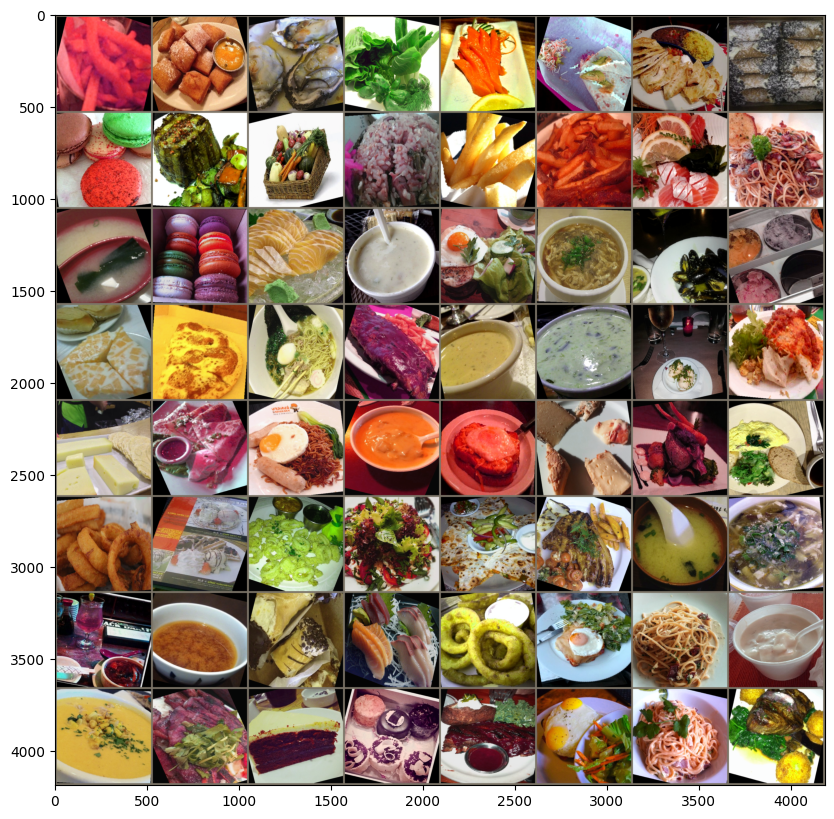

In [ ]:
images, targets = next(iter(train_loader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)
imshow(grid_images)

## Define Model

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, input_channel: int, output_channel: int, img_size: int, num_classes: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//4, out_channels=output_channel//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//2, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Assuming you want to connect to a fully connected layer after flattening
        # Calculate the size of the flattened features after 3 pooling layers
        self.fc_size = output_channel * (img_size // 2**3) * (img_size // 2**3)
        self.fc = nn.Linear(self.fc_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)
        return out

In [ ]:
CLASS_LABELS = len(train_dataset.classes)

MODEL_PARAMS = dict(
    input_channel=3, output_channel=64,
    img_size=IMG_SIZE[0], num_classes=CLASS_LABELS
)

In [ ]:
# Initialize Model
model = ImageClassifier(**MODEL_PARAMS)
model.to(device)

ImageClassifier(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=262144, out_features=11, bias=True)
)

In [ ]:
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

## Training Loop

In [ ]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [ ]:
# Set Epoch Count
num_epochs = 50

In [ ]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            update(loss)
            train_progress.update(1)
            print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{i+1:3}/{train_length}], Loss: {loss.item():.6f}", end="")

        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / len(valid_dataset)
                valid_progress.update(1)

        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs else "")

Running Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/155 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Output()

Epoch [ 5/50], Step [155/155], Loss: 2.189978, Valid Acc: 38.309041%, Valid Loss: 1.782873
Epoch [10/50], Step [155/155], Loss: 1.737080, Valid Acc: 40.320700%, Valid Loss: 1.738361
Epoch [15/50], Step [155/155], Loss: 1.421543, Valid Acc: 46.005827%, Valid Loss: 1.582807
Epoch [20/50], Step [155/155], Loss: 2.183573, Valid Acc: 48.658895%, Valid Loss: 1.506465
Epoch [25/50], Step [155/155], Loss: 1.624028, Valid Acc: 47.113702%, Valid Loss: 1.542553
Epoch [30/50], Step [155/155], Loss: 1.651392, Valid Acc: 47.930032%, Valid Loss: 1.492600
Epoch [32/50], Step [104/155], Loss: 1.477321

In [ ]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"baseline_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Model Evaluation

In [ ]:
# Load Model
model_id = "baseline_model"

model = ImageClassifier(**MODEL_PARAMS)
model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
results = dict(id=[], label=[])
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label'] += [train_dataset.classes[i] for i in preds.cpu().detach().numpy().tolist()]

In [ ]:
# Save Results
results_df = pd.DataFrame(results)

submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_id}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)

results_df.head()